<a href="https://colab.research.google.com/github/pluieciel/applied-ml-uni-lu/blob/master/Part3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Part 3: Adversarial, Transferability and Robustification



We recommand you to use Google Colab to edit and run this notebook. You can also install jupyter on your own computer.

In [1]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 0. Prepare data

You can familiarise yourself with MNIST, a small size dataset, on its Wikipedia article [https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database). MNIST is composed of 28x28 grayscaled images of handwritten digits. This is a classification task with 10 classes (10 digits).

In [5]:
# Data Loading
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [11]:
x = mnist["data"]
y = mnist["target"]

In [7]:
# Data exploration
print(f"Shape of x: {x.shape}")
print(f"Min, max x: {x.min(), x.max()}")
print(f"Shape of y: {y.shape}")
print(f"Classes in y: {np.unique(y)}")

Shape of x: (70000, 784)
Min, max x: (0.0, 255.0)
Shape of y: (70000,)
Classes in y: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [12]:
# Preprocessing
x = torch.from_numpy(x.astype(float)).float()
y = torch.from_numpy(y.astype(int)).type(torch.LongTensor)
# Shape
x = x.reshape(-1, 1, 28, 28)
# Scaler
x = (x - x.min()) / (x.max() - x.min())


In [13]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True)

## 1. Adversarial examples

The goal of this first part is to generate adversarial examples on a simple dataset called MNIST. MNIST is a dataset of 28x28 black and white images that represents hand-written digits, and their associate label 0,1,...,9.

You can use the following ressource to help you [https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#).


1. Train a Neural Network using the PyTorch library.

The architecture of the models and the training hyper-parameters are given below.
We recommend using these parameters, the SGD optimizer and the Cross Entropy loss.


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [15]:
learning_rate = 0.001
momentum=0.9
epochs = 10
batch_size = 64

In [28]:
## YOUR CODE HERE: use SGD with the provided hyperparameters
model_0 = Net().to(device)
optimizer = torch.optim.SGD(model_0.parameters(), lr=learning_rate, momentum=momentum, )

In [17]:
## YOUR CODE HERE: use CrossEntropyLoss.
loss_func = nn.CrossEntropyLoss()

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size/batch_size)):

        # Compute prediction and loss
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [24]:
## GIVEN, to evaluate the progress of the training at each epoch
def val_loop(dataloader, model, loss_fn, epoch_i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Epoch {epoch_i}, Val Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [153]:
def train_model(model, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs):
    # Data processing
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
    )
    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=2000,
        shuffle=True,
        num_workers=2,
    )

    # Main train loop
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_func, optimizer, batch_size)
        val_loop(val_loader, model, loss_func, t+1)
    print("Done!")


In [29]:
## YOUR CODE HERE: train the model using the training function you just implemented.
train_model(model_0, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs)

Epoch 1
-------------------------------


  4%|▎         | 25/700 [00:00<00:02, 242.41it/s]

loss: 2.290561  [   64/44800]


 18%|█▊        | 129/700 [00:00<00:02, 242.40it/s]

loss: 2.314886  [ 6464/44800]


 33%|███▎      | 234/700 [00:00<00:02, 229.21it/s]

loss: 2.296455  [12864/44800]


 46%|████▌     | 321/700 [00:01<00:01, 190.77it/s]

loss: 2.292690  [19264/44800]


 62%|██████▏   | 436/700 [00:02<00:01, 184.48it/s]

loss: 2.271562  [25664/44800]


 77%|███████▋  | 537/700 [00:02<00:00, 187.87it/s]

loss: 2.280647  [32064/44800]


 90%|█████████ | 632/700 [00:03<00:00, 176.03it/s]

loss: 2.219028  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 192.55it/s]


Epoch 0, Val Error: Accuracy: 28.3%, Avg loss: 2.142354
Epoch 2
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 2.072869  [   64/44800]


 21%|██        | 145/700 [00:00<00:02, 221.07it/s]

loss: 1.743191  [ 6464/44800]


 36%|███▌      | 251/700 [00:01<00:01, 249.97it/s]

loss: 1.653175  [12864/44800]


 47%|████▋     | 329/700 [00:01<00:01, 246.53it/s]

loss: 1.240633  [19264/44800]


 62%|██████▏   | 434/700 [00:01<00:01, 253.42it/s]

loss: 1.108503  [25664/44800]


 77%|███████▋  | 539/700 [00:02<00:00, 255.26it/s]

loss: 1.026656  [32064/44800]


 92%|█████████▏| 642/700 [00:02<00:00, 243.58it/s]

loss: 1.134570  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 231.83it/s]


Epoch 1, Val Error: Accuracy: 72.4%, Avg loss: 0.858146
Epoch 3
-------------------------------


  3%|▎         | 24/700 [00:00<00:02, 231.83it/s]

loss: 0.979644  [   64/44800]


 19%|█▉        | 132/700 [00:00<00:02, 259.74it/s]

loss: 0.871315  [ 6464/44800]


 33%|███▎      | 234/700 [00:00<00:01, 249.95it/s]

loss: 0.799887  [12864/44800]


 49%|████▊     | 340/700 [00:01<00:01, 256.55it/s]

loss: 0.559817  [19264/44800]


 64%|██████▍   | 449/700 [00:01<00:00, 257.55it/s]

loss: 0.765164  [25664/44800]


 75%|███████▌  | 528/700 [00:02<00:00, 255.68it/s]

loss: 0.763318  [32064/44800]


 90%|█████████ | 630/700 [00:02<00:00, 211.20it/s]

loss: 0.787051  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 208.04it/s]


Epoch 2, Val Error: Accuracy: 79.1%, Avg loss: 0.666469
Epoch 4
-------------------------------


  7%|▋         | 46/700 [00:00<00:02, 225.02it/s]

loss: 0.847272  [   64/44800]


 21%|██        | 144/700 [00:00<00:02, 231.54it/s]

loss: 0.754715  [ 6464/44800]


 35%|███▌      | 246/700 [00:01<00:01, 234.17it/s]

loss: 0.542142  [12864/44800]


 50%|█████     | 350/700 [00:01<00:01, 247.24it/s]

loss: 0.474756  [19264/44800]


 61%|██████▏   | 429/700 [00:01<00:01, 254.40it/s]

loss: 0.663319  [25664/44800]


 76%|███████▌  | 533/700 [00:02<00:00, 251.64it/s]

loss: 0.660673  [32064/44800]


 91%|█████████ | 636/700 [00:02<00:00, 226.71it/s]

loss: 0.615027  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 227.46it/s]


Epoch 3, Val Error: Accuracy: 81.7%, Avg loss: 0.577085
Epoch 5
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.681106  [   64/44800]


 19%|█▊        | 130/700 [00:00<00:03, 172.74it/s]

loss: 0.455811  [ 6464/44800]


 32%|███▏      | 222/700 [00:01<00:02, 180.63it/s]

loss: 0.505587  [12864/44800]


 46%|████▌     | 321/700 [00:01<00:01, 190.71it/s]

loss: 0.615100  [19264/44800]


 62%|██████▏   | 436/700 [00:02<00:01, 182.81it/s]

loss: 0.606286  [25664/44800]


 78%|███████▊  | 544/700 [00:02<00:00, 215.99it/s]

loss: 0.424270  [32064/44800]


 92%|█████████▏| 644/700 [00:03<00:00, 244.13it/s]

loss: 0.507458  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 193.72it/s]


Epoch 4, Val Error: Accuracy: 84.7%, Avg loss: 0.508509
Epoch 6
-------------------------------


  3%|▎         | 22/700 [00:00<00:03, 214.42it/s]

loss: 0.552611  [   64/44800]


 22%|██▏       | 151/700 [00:00<00:02, 248.79it/s]

loss: 0.525519  [ 6464/44800]


 32%|███▏      | 226/700 [00:00<00:01, 243.52it/s]

loss: 0.427341  [12864/44800]


 47%|████▋     | 332/700 [00:01<00:01, 258.52it/s]

loss: 0.685311  [19264/44800]


 62%|██████▏   | 436/700 [00:01<00:01, 248.03it/s]

loss: 0.545971  [25664/44800]


 77%|███████▋  | 537/700 [00:02<00:00, 242.88it/s]

loss: 0.319095  [32064/44800]


 92%|█████████▏| 642/700 [00:02<00:00, 250.19it/s]

loss: 0.433559  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 240.50it/s]


Epoch 5, Val Error: Accuracy: 86.4%, Avg loss: 0.456020
Epoch 7
-------------------------------


  3%|▎         | 22/700 [00:00<00:03, 213.14it/s]

loss: 0.287037  [   64/44800]


 21%|██▏       | 150/700 [00:00<00:02, 246.11it/s]

loss: 0.532983  [ 6464/44800]


 36%|███▌      | 253/700 [00:01<00:01, 250.83it/s]

loss: 0.536486  [12864/44800]


 47%|████▋     | 332/700 [00:01<00:01, 252.19it/s]

loss: 0.752928  [19264/44800]


 62%|██████▏   | 433/700 [00:01<00:01, 247.09it/s]

loss: 0.814629  [25664/44800]


 77%|███████▋  | 538/700 [00:02<00:00, 252.77it/s]

loss: 0.435027  [32064/44800]


 92%|█████████▏| 646/700 [00:02<00:00, 258.36it/s]

loss: 0.343332  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 242.75it/s]


Epoch 6, Val Error: Accuracy: 87.2%, Avg loss: 0.429612
Epoch 8
-------------------------------


  3%|▎         | 22/700 [00:00<00:03, 217.71it/s]

loss: 0.561910  [   64/44800]


 20%|██        | 143/700 [00:00<00:02, 235.24it/s]

loss: 0.342095  [ 6464/44800]


 35%|███▌      | 248/700 [00:01<00:01, 253.20it/s]

loss: 0.354591  [12864/44800]


 47%|████▋     | 326/700 [00:01<00:01, 250.21it/s]

loss: 0.444492  [19264/44800]


 61%|██████▏   | 429/700 [00:01<00:01, 246.39it/s]

loss: 0.240086  [25664/44800]


 76%|███████▌  | 532/700 [00:02<00:00, 240.77it/s]

loss: 0.371041  [32064/44800]


 89%|████████▉ | 625/700 [00:02<00:00, 198.84it/s]

loss: 0.441443  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 218.46it/s]


Epoch 7, Val Error: Accuracy: 88.2%, Avg loss: 0.392648
Epoch 9
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.379855  [   64/44800]


 18%|█▊        | 128/700 [00:00<00:03, 179.54it/s]

loss: 0.354329  [ 6464/44800]


 32%|███▏      | 225/700 [00:01<00:02, 188.50it/s]

loss: 0.352794  [12864/44800]


 46%|████▌     | 320/700 [00:01<00:02, 177.07it/s]

loss: 0.341757  [19264/44800]


 61%|██████▏   | 429/700 [00:02<00:01, 200.29it/s]

loss: 0.231849  [25664/44800]


 76%|███████▌  | 529/700 [00:02<00:00, 235.61it/s]

loss: 0.499404  [32064/44800]


 90%|█████████ | 631/700 [00:03<00:00, 234.82it/s]

loss: 0.421649  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 200.33it/s]


Epoch 8, Val Error: Accuracy: 89.0%, Avg loss: 0.371126
Epoch 10
-------------------------------


  3%|▎         | 23/700 [00:00<00:02, 227.45it/s]

loss: 0.282550  [   64/44800]


 22%|██▏       | 151/700 [00:00<00:02, 253.87it/s]

loss: 0.260308  [ 6464/44800]


 33%|███▎      | 229/700 [00:00<00:01, 252.56it/s]

loss: 0.440190  [12864/44800]


 47%|████▋     | 332/700 [00:01<00:01, 245.45it/s]

loss: 0.564872  [19264/44800]


 62%|██████▏   | 437/700 [00:01<00:01, 252.58it/s]

loss: 0.270534  [25664/44800]


 77%|███████▋  | 542/700 [00:02<00:00, 251.53it/s]

loss: 0.277600  [32064/44800]


 92%|█████████▏| 644/700 [00:02<00:00, 246.27it/s]

loss: 0.271359  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 241.30it/s]


Epoch 9, Val Error: Accuracy: 89.2%, Avg loss: 0.356655
Done!


2. Evaluate clean accuracy of the Neural Network using a test set that has not been used for training.

In [51]:
# Set model into evaluation mode
model_0.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [52]:
## YOUR CODE HERE: Evaluate model accuracy
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            #test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    #test_loss /= num_batches
    correct /= size
    return correct

def test_model(model, x_test, y_test, loss_func):
    # Data processing
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=2000,
        shuffle=False,
        num_workers=2,
    )

    # Main loop
    return test_loop(test_loader, model, loss_func)

accuracy = test_model(model_0, x_test, y_test, loss_func)
print(f"Clean accuracy of the model is {accuracy}.")

Clean accuracy of the model is 0.9517857142857142.


3. Implement and execute the PGD attack on 1000 examples of the testing set. The hyperparameters of PGD are given below.
The perturbation is bounded by a maximum L-infinity norm, called epsilon (eps), which means that each pixel can be perturbed between -eps and +eps. We initialy set the maximum perturbation to eps = 32/255. For simplicity, you can set the step size alpha = epsilon / 10, and run PGD with only one random restart.

You can find the description of PGD in the paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083) and an example of another adversarial attack on the PyTorch documentation [https://pytorch.org/tutorials/beginner/fgsm_tutorial.html](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).
Tips: use the F.cross_entropy loss during the attack.


In [32]:
n_examples = 1000
eps = 32/255
n_iter = 50
alpha = eps / 10


In [ ]:
! pip install advertorch

for modify the dependency issue:

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, container_abcs.Iterable):
        for elem in x:
            zero_gradients(elem)

In [54]:
## YOUR CODE HERE: Generate adversarial examples
from advertorch.attacks import LinfPGDAttack
adversary = LinfPGDAttack(model_0,
                          loss_fn=nn.CrossEntropyLoss(),
                          eps=eps,
                          nb_iter=n_iter,
                          eps_iter=alpha,
                          rand_init=True,
                          clip_min=0.0,
                          clip_max=1.0,
                          targeted=False)


In [59]:

def attack_loop(dataloader, model, loss_fn, adversary):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0


    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        perturbed_image = adversary.perturb(X, y)
        pred = model(perturbed_image)
        #test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    #test_loss /= num_batches
    correct /= size
    return correct

def attack_model(model, x_test, y_test, loss_func, n_examples, adversary):
    # Data processing
    test_dataset = TensorDataset(x_test[:n_examples], y_test[:n_examples])
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=2000,
        shuffle=False,
        num_workers=2,
    )

    # Main loop

    return attack_loop(test_loader, model, loss_func, adversary)

accuracy = attack_model(model_0, x_test, y_test, loss_func, n_examples, adversary)
print(f"Attack accuracy of the model is {accuracy}.")

Attack accuracy of the model is 0.534.


4. Show the robust accuracy of model_0, that is the accuracy of the model on the adversarial examples.

In [60]:
## YOUR CODE HERE: Evaluate model robust accuracy
accuracy = attack_model(model_0, x_test, y_test, loss_func, len(y_test), adversary)
print(f"Attack accuracy of the model is {accuracy}.")

Attack accuracy of the model is 0.522.


5. Show the impact of the maximum perturbation allowed (denoted epsilon).

In [62]:
eps = [8/255, 16/255, 32/255, 64/255]
#alpha = [e/10 for e in eps]

In [63]:
## YOUR CODE HERE: compute the adversarial examples for each provided epsilon
## (maximum l-infinity norm of the perturbation), and compute the associated robust accuracy
## Use a graph to display your result. You may use the [Matplotlib] (https://matplotlib.org/stable/index.html).
accuracy = []
for e in eps:
    alpha = e/10
    adversary = LinfPGDAttack(model_0,
                              loss_fn=nn.CrossEntropyLoss(),
                              eps=e, #<-
                              nb_iter=n_iter,
                              eps_iter=alpha, #<-
                              rand_init=True,
                              clip_min=0.0,
                              clip_max=1.0,
                              targeted=False)
    accuracy.append(attack_model(model_0, x_test, y_test, loss_func, len(y_test), adversary))

Text(0, 0.5, 'accuracy')

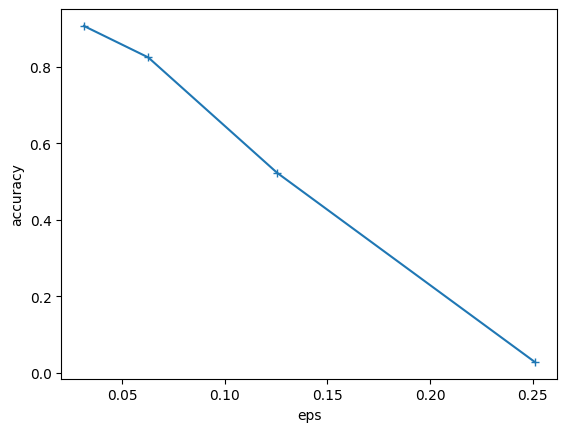

In [72]:
plt.plot(eps, accuracy, "+-")
plt.xlabel('eps')
plt.ylabel('accuracy')

6. Using matplotlib, plot 10 adversarial examples, along with their corresponding original images. Choose one original image classified per class (the 10 class should be represented). For each image (adversarial and original), add on the plot the predicted class of the image.


In [80]:
## YOUR CODE HERE

In [125]:
from torch.utils.data import Subset
idx = torch.tensor([(y_test==i).nonzero()[0] for i in range(10)])
show_dataset = Subset(TensorDataset(x_test, y_test), idx)
show_loader = DataLoader(
        dataset=show_dataset,
        shuffle=False,)

In [133]:
pred = []
pred_ad = []
ad_img = []
for X, y in show_loader:
    X, y = X.to(device), y.to(device)

    perturbed_image = adversary.perturb(X, y)
    ad_img.append(perturbed_image)
    pred.append(model_0(X).argmax(1))
    pred_ad.append(model_0(perturbed_image).argmax(1))

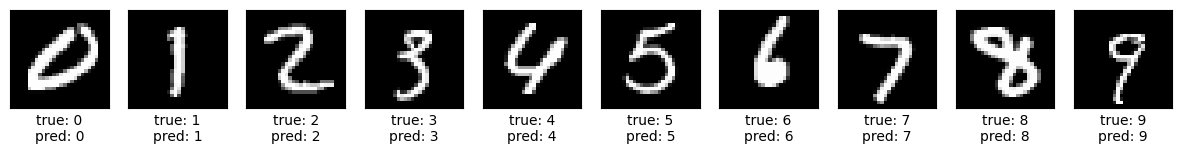

In [140]:
plt.figure(figsize=(15,20))
for i,(X,y) in enumerate(show_loader):
    plt.subplot(1,10,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel(f"true: {y[0].item()}\npred: {pred[i][0].item()}")
    plt.imshow(X[0][0], cmap="gray")

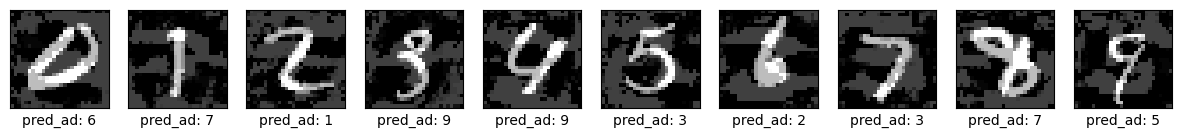

In [149]:
plt.figure(figsize=(15,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.xlabel(f"pred_ad: {pred_ad[i].item()}")
    plt.imshow(ad_img[i][0][0].cpu(), cmap="gray")

**Question**: Please comment your results of this section.

**ANSWER HERE**

the attack is successful to fail the model, while the images are still ok for human to recognize.


## 2. Transferability

In this section we will see how adversarial examples generated on one model can be adversarial on another model using a different architecture.
Let suppose a second model which parameters are unknown. For instance, it could be a model deploy on a cloud platform. We will use the examples generated in Section 1 on model_0 to fool this new model denoted model_1.
We say that model_0 is a surrogate for model_1.

1. Define a neural network architecture for MNIST different than the one used in Section 1.

In [150]:
## GIVEN
class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

2. Train the neural network model_1 with the same hyperparameters as model_0


In [151]:
## YOUR CODE HERE
model_1 = FullyConnectedNetwork().to(device)
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate, momentum=momentum)  # create a new optimizer object when you train a new model

In [152]:
train_model(model_1, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs)

Epoch 1
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 2.303332  [   64/44800]


 20%|██        | 142/700 [00:00<00:01, 288.78it/s]

loss: 2.251980  [ 6464/44800]


 33%|███▎      | 229/700 [00:00<00:01, 277.60it/s]

loss: 2.180791  [12864/44800]


 50%|████▉     | 348/700 [00:01<00:01, 287.83it/s]

loss: 2.081358  [19264/44800]


 62%|██████▏   | 437/700 [00:01<00:00, 290.55it/s]

loss: 1.859241  [25664/44800]


 79%|███████▉  | 555/700 [00:01<00:00, 285.82it/s]

loss: 1.667254  [32064/44800]


 92%|█████████▏| 645/700 [00:02<00:00, 287.92it/s]

loss: 1.153140  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 274.92it/s]


Epoch 0, Val Error: Accuracy: 78.9%, Avg loss: 0.985090
Epoch 2
-------------------------------


  3%|▎         | 23/700 [00:00<00:02, 226.58it/s]

loss: 1.134645  [   64/44800]


 21%|██        | 145/700 [00:00<00:01, 286.85it/s]

loss: 0.860918  [ 6464/44800]


 33%|███▎      | 234/700 [00:00<00:01, 277.39it/s]

loss: 0.649880  [12864/44800]


 51%|█████     | 356/700 [00:01<00:01, 289.81it/s]

loss: 0.690856  [19264/44800]


 64%|██████▍   | 447/700 [00:01<00:00, 294.74it/s]

loss: 0.609149  [25664/44800]


 76%|███████▌  | 533/700 [00:01<00:00, 240.70it/s]

loss: 0.529935  [32064/44800]


 90%|█████████ | 631/700 [00:02<00:00, 230.88it/s]

loss: 0.371293  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 245.33it/s]


Epoch 1, Val Error: Accuracy: 87.4%, Avg loss: 0.477131
Epoch 3
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.489383  [   64/44800]


 19%|█▉        | 133/700 [00:00<00:02, 192.12it/s]

loss: 0.485836  [ 6464/44800]


 34%|███▍      | 240/700 [00:01<00:02, 209.25it/s]

loss: 0.479947  [12864/44800]


 47%|████▋     | 326/700 [00:01<00:01, 206.90it/s]

loss: 0.412686  [19264/44800]


 62%|██████▏   | 434/700 [00:02<00:01, 204.10it/s]

loss: 0.348822  [25664/44800]


 79%|███████▉  | 552/700 [00:02<00:00, 269.95it/s]

loss: 0.391801  [32064/44800]


 92%|█████████▏| 641/700 [00:02<00:00, 280.47it/s]

loss: 0.319431  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 220.44it/s]


Epoch 2, Val Error: Accuracy: 89.5%, Avg loss: 0.379800
Epoch 4
-------------------------------


  4%|▎         | 26/700 [00:00<00:02, 257.30it/s]

loss: 0.510453  [   64/44800]


 20%|██        | 140/700 [00:00<00:01, 280.96it/s]

loss: 0.459431  [ 6464/44800]


 36%|███▋      | 255/700 [00:00<00:01, 268.32it/s]

loss: 0.285511  [12864/44800]


 49%|████▉     | 344/700 [00:01<00:01, 283.80it/s]

loss: 0.351872  [19264/44800]


 62%|██████▏   | 435/700 [00:01<00:00, 289.10it/s]

loss: 0.242608  [25664/44800]


 79%|███████▉  | 554/700 [00:02<00:00, 278.54it/s]

loss: 0.258273  [32064/44800]


 92%|█████████▏| 645/700 [00:02<00:00, 289.26it/s]

loss: 0.206114  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 264.97it/s]


Epoch 3, Val Error: Accuracy: 90.2%, Avg loss: 0.341335
Epoch 5
-------------------------------


  4%|▎         | 25/700 [00:00<00:02, 242.69it/s]

loss: 0.342728  [   64/44800]


 20%|██        | 142/700 [00:00<00:01, 285.42it/s]

loss: 0.428146  [ 6464/44800]


 33%|███▎      | 232/700 [00:00<00:01, 289.50it/s]

loss: 0.393621  [12864/44800]


 50%|█████     | 350/700 [00:01<00:01, 283.83it/s]

loss: 0.195264  [19264/44800]


 62%|██████▏   | 436/700 [00:01<00:00, 277.05it/s]

loss: 0.294921  [25664/44800]


 79%|███████▉  | 555/700 [00:01<00:00, 286.41it/s]

loss: 0.431727  [32064/44800]


 92%|█████████▏| 642/700 [00:02<00:00, 269.37it/s]

loss: 0.428517  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 271.31it/s]


Epoch 4, Val Error: Accuracy: 91.0%, Avg loss: 0.317173
Epoch 6
-------------------------------


  4%|▎         | 26/700 [00:00<00:02, 253.56it/s]

loss: 0.235717  [   64/44800]


 20%|██        | 142/700 [00:00<00:01, 282.77it/s]

loss: 0.301338  [ 6464/44800]


 37%|███▋      | 259/700 [00:00<00:01, 285.39it/s]

loss: 0.200138  [12864/44800]


 50%|████▉     | 348/700 [00:01<00:01, 287.84it/s]

loss: 0.421459  [19264/44800]


 62%|██████▏   | 437/700 [00:01<00:00, 291.16it/s]

loss: 0.417932  [25664/44800]


 80%|███████▉  | 559/700 [00:01<00:00, 296.08it/s]

loss: 0.353392  [32064/44800]


 93%|█████████▎| 650/700 [00:02<00:00, 295.38it/s]

loss: 0.247458  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 277.33it/s]


Epoch 5, Val Error: Accuracy: 91.5%, Avg loss: 0.295552
Epoch 7
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.176084  [   64/44800]


 20%|█▉        | 137/700 [00:00<00:02, 191.22it/s]

loss: 0.305832  [ 6464/44800]


 32%|███▏      | 226/700 [00:01<00:02, 203.65it/s]

loss: 0.299190  [12864/44800]


 47%|████▋     | 332/700 [00:01<00:01, 203.35it/s]

loss: 0.215194  [19264/44800]


 64%|██████▎   | 446/700 [00:02<00:01, 222.86it/s]

loss: 0.205237  [25664/44800]


 76%|███████▋  | 535/700 [00:02<00:00, 211.92it/s]

loss: 0.171630  [32064/44800]


 90%|████████▉ | 629/700 [00:03<00:00, 204.24it/s]

loss: 0.221959  [38464/44800]


100%|██████████| 700/700 [00:03<00:00, 199.74it/s]


Epoch 6, Val Error: Accuracy: 92.0%, Avg loss: 0.281345
Epoch 8
-------------------------------


  4%|▎         | 25/700 [00:00<00:02, 249.91it/s]

loss: 0.474291  [   64/44800]


 20%|██        | 141/700 [00:00<00:01, 282.40it/s]

loss: 0.435895  [ 6464/44800]


 33%|███▎      | 230/700 [00:00<00:01, 285.76it/s]

loss: 0.251878  [12864/44800]


 50%|████▉     | 348/700 [00:01<00:01, 283.99it/s]

loss: 0.307365  [19264/44800]


 63%|██████▎   | 438/700 [00:01<00:00, 283.10it/s]

loss: 0.251387  [25664/44800]


 80%|███████▉  | 558/700 [00:01<00:00, 287.99it/s]

loss: 0.156831  [32064/44800]


 92%|█████████▏| 647/700 [00:02<00:00, 288.87it/s]

loss: 0.274582  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 276.62it/s]


Epoch 7, Val Error: Accuracy: 92.4%, Avg loss: 0.266980
Epoch 9
-------------------------------


  4%|▍         | 27/700 [00:00<00:02, 269.35it/s]

loss: 0.318995  [   64/44800]


 20%|██        | 143/700 [00:00<00:01, 283.70it/s]

loss: 0.314374  [ 6464/44800]


 33%|███▎      | 230/700 [00:00<00:01, 276.82it/s]

loss: 0.302246  [12864/44800]


 51%|█████     | 358/700 [00:01<00:01, 307.87it/s]

loss: 0.390731  [19264/44800]


 64%|██████▍   | 450/700 [00:01<00:00, 291.52it/s]

loss: 0.186544  [25664/44800]


 78%|███████▊  | 545/700 [00:01<00:00, 302.98it/s]

loss: 0.126715  [32064/44800]


 91%|█████████▏| 640/700 [00:02<00:00, 310.04it/s]

loss: 0.172346  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 286.58it/s]


Epoch 8, Val Error: Accuracy: 92.9%, Avg loss: 0.251371
Epoch 10
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.384558  [   64/44800]


 21%|██        | 146/700 [00:00<00:01, 291.06it/s]

loss: 0.293803  [ 6464/44800]


 34%|███▍      | 237/700 [00:00<00:01, 288.22it/s]

loss: 0.195460  [12864/44800]


 51%|█████     | 354/700 [00:01<00:01, 284.16it/s]

loss: 0.164066  [19264/44800]


 64%|██████▍   | 448/700 [00:01<00:00, 300.90it/s]

loss: 0.388329  [25664/44800]


 77%|███████▋  | 541/700 [00:01<00:00, 299.15it/s]

loss: 0.248513  [32064/44800]


 95%|█████████▍| 662/700 [00:02<00:00, 296.89it/s]

loss: 0.168177  [38464/44800]


100%|██████████| 700/700 [00:02<00:00, 280.85it/s]


Epoch 9, Val Error: Accuracy: 93.2%, Avg loss: 0.241582
Done!


3. What is the ratio of successful adversarial examples on model_0 that transfers to model_1 (ie. that are also adversarial for model_1)?


In [154]:
model_1.eval()
## YOUR CODE HERE
accuracy = test_model(model_1, x_test, y_test, loss_func)
print(f"Clean accuracy of the model is {accuracy}.")

Clean accuracy of the model is 0.9265.


In [156]:
# adversary is from model_0, we dont need to change
accuracy = attack_model(model_1, x_test, y_test, loss_func, len(y_test), adversary)
print(f"Attack accuracy of the model is {accuracy}.")

Attack accuracy of the model is 0.09435714285714286.


What do you conclude about the robustness of the model? Can [secrecy](https://en.wikipedia.org/wiki/Security_through_obscurity) defend a model?

**ANSWER HERE**

the attack generated from model_0 is also effective for model_1. which means once we have the data, we can train a model_0 for attack without understanding the detail of model_1.

the secrecy cannot defend a model.

## 3. Use adversarial training to robustify the model

Adversarial training is a common method to robustify models to adversarial examples as described in this paper [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083). In this section you should update the training loop such that 3/4 of the batch is used for training while the remaining forth is first perturbed with PGD and then used for training. You can limit the number of iterations of PDG to 10. Use model_0 architecture from Section 1 in this section.

1. Train model_robust using adversarial training. You may want to run it for additional epoch (x2) to reach a similar clean accuracy.

In [175]:
n_iter = 10  # less iterations to accelerate training. But once trained, we will still evaluate the robust accuracy on more iterations for a more powerful attack.
eps = 32/255
alpha = eps / 5
model_robust = Net().to(device)  # newly initialized NN

In [176]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    adv_size = int(batch_size/4)
    for batch, (X, y) in tqdm(enumerate(dataloader), total=int(size/batch_size)):

        # Generate adversarial examples for a forth of the data

        model.eval()
        ## YOUR CODE HERE
        X, y = X.to(device), y.to(device)

        perturbed_image = adversary.perturb(X[0:adv_size], y[0:adv_size]) # reuse the same adversary from model_0 with biggest eps
        X[0:adv_size] = perturbed_image[0:adv_size] # replace first 1/4 of the batch with adversarial input

        model.train()
        # Compute prediction and loss

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [177]:
## YOUR CODE HERE: The rest of training implementation is unchanged.
## Do not reuse the same optimizer object!!!
optimizer = torch.optim.SGD(model_robust.parameters(), lr=learning_rate, momentum=momentum)

In [178]:
train_model(model_robust, x_train, y_train, x_val, y_val, optimizer, batch_size, loss_func, epochs)

Epoch 1
-------------------------------


  0%|          | 1/700 [00:00<01:15,  9.20it/s]

loss: 2.313985  [   64/44800]


 15%|█▍        | 103/700 [00:09<00:51, 11.68it/s]

loss: 2.297368  [ 6464/44800]


 29%|██▊       | 201/700 [00:18<00:51,  9.66it/s]

loss: 2.298446  [12864/44800]


 43%|████▎     | 302/700 [00:27<00:33, 11.73it/s]

loss: 2.284514  [19264/44800]


 58%|█████▊    | 403/700 [00:36<00:25, 11.68it/s]

loss: 2.276020  [25664/44800]


 72%|███████▏  | 502/700 [00:45<00:20,  9.64it/s]

loss: 2.243437  [32064/44800]


 86%|████████▌ | 603/700 [00:54<00:08, 11.58it/s]

loss: 2.237300  [38464/44800]


100%|██████████| 700/700 [01:04<00:00, 10.91it/s]


Epoch 1, Val Error: Accuracy: 23.5%, Avg loss: 2.176187
Epoch 2
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 2.180242  [   64/44800]


 15%|█▍        | 102/700 [00:09<01:03,  9.39it/s]

loss: 2.024127  [ 6464/44800]


 29%|██▉       | 202/700 [00:20<00:42, 11.61it/s]

loss: 1.807629  [12864/44800]


 43%|████▎     | 302/700 [00:31<01:00,  6.60it/s]

loss: 1.757517  [19264/44800]


 57%|█████▋    | 402/700 [00:42<00:25, 11.59it/s]

loss: 1.636640  [25664/44800]


 72%|███████▏  | 501/700 [00:51<00:20,  9.92it/s]

loss: 1.609120  [32064/44800]


 86%|████████▌ | 602/700 [01:00<00:08, 11.85it/s]

loss: 1.433531  [38464/44800]


100%|██████████| 700/700 [01:09<00:00, 10.02it/s]


Epoch 2, Val Error: Accuracy: 66.5%, Avg loss: 1.070809
Epoch 3
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 1.560172  [   64/44800]


 14%|█▍        | 101/700 [00:12<02:52,  3.47it/s]

loss: 1.495420  [ 6464/44800]


 29%|██▉       | 202/700 [00:23<00:59,  8.38it/s]

loss: 1.563488  [12864/44800]


 43%|████▎     | 302/700 [00:36<00:34, 11.42it/s]

loss: 1.209962  [19264/44800]


 58%|█████▊    | 403/700 [00:46<00:25, 11.73it/s]

loss: 1.173959  [25664/44800]


 72%|███████▏  | 502/700 [00:59<00:23,  8.40it/s]

loss: 0.953431  [32064/44800]


 86%|████████▌ | 603/700 [01:12<00:09, 10.41it/s]

loss: 1.111666  [38464/44800]


100%|██████████| 700/700 [01:22<00:00,  8.48it/s]


Epoch 3, Val Error: Accuracy: 73.6%, Avg loss: 0.839763
Epoch 4
-------------------------------


  0%|          | 1/700 [00:00<02:54,  4.01it/s]

loss: 0.985437  [   64/44800]


 15%|█▍        | 102/700 [00:10<01:08,  8.71it/s]

loss: 1.041618  [ 6464/44800]


 29%|██▉       | 202/700 [00:22<00:41, 11.97it/s]

loss: 1.123865  [12864/44800]


 43%|████▎     | 302/700 [00:31<00:33, 11.83it/s]

loss: 0.904967  [19264/44800]


 57%|█████▋    | 402/700 [00:40<00:31,  9.36it/s]

loss: 0.782108  [25664/44800]


 72%|███████▏  | 502/700 [00:49<00:16, 11.78it/s]

loss: 0.945893  [32064/44800]


 86%|████████▌ | 602/700 [00:58<00:08, 11.88it/s]

loss: 0.907544  [38464/44800]


100%|██████████| 700/700 [01:11<00:00,  9.74it/s]


Epoch 4, Val Error: Accuracy: 78.1%, Avg loss: 0.719659
Epoch 5
-------------------------------


  0%|          | 1/700 [00:00<01:10,  9.95it/s]

loss: 0.958546  [   64/44800]


 15%|█▍        | 102/700 [00:09<01:05,  9.19it/s]

loss: 1.058915  [ 6464/44800]


 29%|██▉       | 203/700 [00:19<00:42, 11.62it/s]

loss: 0.965661  [12864/44800]


 43%|████▎     | 303/700 [00:28<00:34, 11.44it/s]

loss: 1.080140  [19264/44800]


 57%|█████▋    | 402/700 [00:37<00:32,  9.24it/s]

loss: 0.809404  [25664/44800]


 72%|███████▏  | 503/700 [00:46<00:16, 11.91it/s]

loss: 0.772751  [32064/44800]


 86%|████████▌ | 602/700 [00:55<00:08, 11.63it/s]

loss: 1.014088  [38464/44800]


100%|██████████| 700/700 [01:03<00:00, 10.94it/s]


Epoch 5, Val Error: Accuracy: 80.4%, Avg loss: 0.641738
Epoch 6
-------------------------------


  0%|          | 2/700 [00:00<01:25,  8.18it/s]

loss: 0.696759  [   64/44800]


 15%|█▍        | 103/700 [00:09<00:50, 11.77it/s]

loss: 0.817949  [ 6464/44800]


 29%|██▉       | 202/700 [00:19<00:45, 11.02it/s]

loss: 0.862249  [12864/44800]


 43%|████▎     | 302/700 [00:27<00:41,  9.64it/s]

loss: 0.651327  [19264/44800]


 58%|█████▊    | 403/700 [00:37<00:24, 12.04it/s]

loss: 0.807205  [25664/44800]


 72%|███████▏  | 503/700 [00:46<00:16, 11.85it/s]

loss: 0.854272  [32064/44800]


 86%|████████▌ | 601/700 [00:54<00:08, 11.26it/s]

loss: 0.527969  [38464/44800]


100%|██████████| 700/700 [01:04<00:00, 10.89it/s]


Epoch 6, Val Error: Accuracy: 82.7%, Avg loss: 0.578471
Epoch 7
-------------------------------


  0%|          | 1/700 [00:00<01:18,  8.92it/s]

loss: 0.693874  [   64/44800]


 15%|█▍        | 102/700 [00:09<00:50, 11.76it/s]

loss: 0.681467  [ 6464/44800]


 29%|██▉       | 202/700 [00:18<00:48, 10.31it/s]

loss: 0.790534  [12864/44800]


 43%|████▎     | 302/700 [00:27<00:34, 11.50it/s]

loss: 0.658045  [19264/44800]


 58%|█████▊    | 403/700 [00:36<00:25, 11.67it/s]

loss: 0.831875  [25664/44800]


 72%|███████▏  | 501/700 [00:45<00:16, 11.87it/s]

loss: 0.764494  [32064/44800]


 86%|████████▌ | 602/700 [00:54<00:08, 11.62it/s]

loss: 0.605380  [38464/44800]


100%|██████████| 700/700 [01:03<00:00, 10.98it/s]


Epoch 7, Val Error: Accuracy: 83.9%, Avg loss: 0.529127
Epoch 8
-------------------------------


  0%|          | 1/700 [00:00<01:15,  9.27it/s]

loss: 0.787763  [   64/44800]


 14%|█▍        | 101/700 [00:08<00:54, 11.09it/s]

loss: 0.846501  [ 6464/44800]


 29%|██▉       | 203/700 [00:18<00:42, 11.71it/s]

loss: 0.678537  [12864/44800]


 43%|████▎     | 302/700 [00:27<00:34, 11.48it/s]

loss: 0.821766  [19264/44800]


 57%|█████▋    | 402/700 [00:36<00:27, 10.86it/s]

loss: 0.807537  [25664/44800]


 72%|███████▏  | 502/700 [00:45<00:17, 11.42it/s]

loss: 0.640533  [32064/44800]


 86%|████████▌ | 603/700 [00:55<00:08, 11.38it/s]

loss: 0.540105  [38464/44800]


100%|██████████| 700/700 [01:03<00:00, 11.02it/s]


Epoch 8, Val Error: Accuracy: 85.7%, Avg loss: 0.475730
Epoch 9
-------------------------------


  0%|          | 2/700 [00:00<01:33,  7.43it/s]

loss: 0.683762  [   64/44800]


 15%|█▍        | 102/700 [00:09<00:51, 11.60it/s]

loss: 0.611583  [ 6464/44800]


 29%|██▉       | 202/700 [00:18<00:42, 11.81it/s]

loss: 0.642635  [12864/44800]


 43%|████▎     | 302/700 [00:27<00:35, 11.32it/s]

loss: 0.610551  [19264/44800]


 57%|█████▋    | 402/700 [00:36<00:25, 11.88it/s]

loss: 0.556377  [25664/44800]


 72%|███████▏  | 502/700 [00:46<00:17, 11.51it/s]

loss: 0.688849  [32064/44800]


 86%|████████▌ | 602/700 [00:54<00:08, 11.77it/s]

loss: 0.561453  [38464/44800]


100%|██████████| 700/700 [01:03<00:00, 10.98it/s]


Epoch 9, Val Error: Accuracy: 86.1%, Avg loss: 0.463003
Epoch 10
-------------------------------


  0%|          | 0/700 [00:00<?, ?it/s]

loss: 0.540595  [   64/44800]


 15%|█▍        | 102/700 [00:09<00:50, 11.74it/s]

loss: 1.049588  [ 6464/44800]


 29%|██▉       | 202/700 [00:17<00:42, 11.83it/s]

loss: 0.498464  [12864/44800]


 43%|████▎     | 303/700 [00:27<00:34, 11.51it/s]

loss: 0.532449  [19264/44800]


 57%|█████▋    | 402/700 [00:36<00:27, 10.91it/s]

loss: 0.581487  [25664/44800]


 72%|███████▏  | 502/700 [00:45<00:16, 11.77it/s]

loss: 0.800793  [32064/44800]


 86%|████████▌ | 602/700 [00:54<00:08, 11.82it/s]

loss: 0.639419  [38464/44800]


100%|██████████| 700/700 [01:03<00:00, 10.95it/s]


Epoch 10, Val Error: Accuracy: 86.9%, Avg loss: 0.434610
Done!


2. Compare the robust accuracies of model_0 and model_robust using the same hyperparameters of PGD for different eps size, use a graph to show your results.

In [179]:
n_examples = 1000
n_iter = 50
eps = [8/255, 16/255, 32/255, 64/255]
#alpha = [e/10 for e in eps]

In [181]:
## YOUR CODE HERE
accuracy_0 = []
accuracy_robust = []
for e in eps:
    alpha = e/10
    for i in range(2):
        adversary = LinfPGDAttack((model_0, model_robust)[i], #<-
                                loss_fn=nn.CrossEntropyLoss(),
                                eps=e, #<-
                                nb_iter=n_iter,
                                eps_iter=alpha, #<-
                                rand_init=True,
                                clip_min=0.0,
                                clip_max=1.0,
                                targeted=False)
        if i==0:
            accuracy_0.append(attack_model(model_0, x_test, y_test, loss_func, n_examples, adversary))
        else:
            accuracy_robust.append(attack_model(model_robust, x_test, y_test, loss_func, n_examples, adversary))

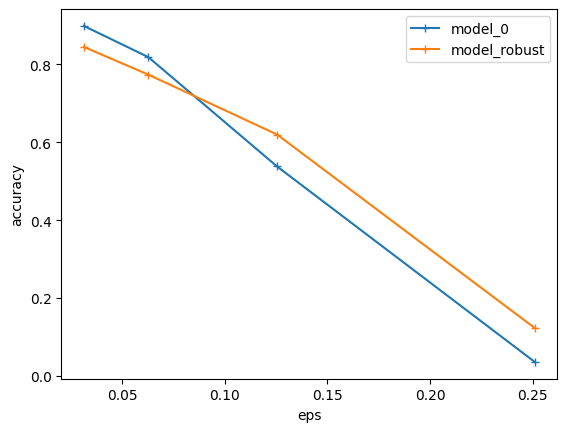

In [186]:
plt.plot(eps, accuracy_0, "+-", label="model_0")
plt.plot(eps, accuracy_robust, "+-", label="model_robust")
plt.xlabel('eps')
plt.ylabel('accuracy')
plt.legend(loc="upper right")
plt.show()

**Questions**: Please comment your results. Does adversarial training appears to be a valid defense? Please develop threads to validity of the robust accuracy evaluation carried out here. What could be done to improve the evaluation of the robustness of the model?

**ANSWER HERE**

the robust model is slight weaker than model_0 with small eps, but with larger eps, the robust model is better. That means, the robust training is working.

use more adverserial data to train the model. i.e.: train on full set of train data, than on full set of adverserial data of all train data.